# This notebook contains the results for cluster analysis applied to velocity models from different azimuths

In [1]:
## importing the dependencies
# importing necessary dependencies.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import obspy
import seaborn as sns
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import tsfel

import matplotlib.cm as cm
from matplotlib.colors import Normalize  
from matplotlib import ticker


from scipy.interpolate import griddata as gd
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

from cartopy.io.img_tiles import Stamen
import pygmt

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.weight'] = 'bold'

In [29]:
### Checking the folders present in the data directory
files = glob('Data/*')

file = glob('Data/*')[2]
vs = glob(file + '/*')

PO_HB = pd.read_csv(files[4], header = None, sep=' ')
X5 = pd.read_csv(files[5], header = None, sep=' ')

### storing station names and coordinates 
stations = []
for i in range(len(vs)):
    stations.append(vs[i].split('/')[2].split('_')[1])
    
stn_db = pd.concat([PO_HB,X5])
stn_db.index = stn_db[2]

new_mod_lons = []
new_mod_lats = []

for i in range(len(stations)):
    new_mod_lons.append(stn_db.at[stations[i],0])
    new_mod_lats.append(stn_db.at[stations[i],1])
    
features = []
vs_profiles = []
for i in tqdm(range(len(vs))):
    shear_velocity = pd.read_csv(vs[i], header=None, sep = ' ')[0]
    depth = pd.read_csv(vs[i], header=None, sep = ' ')[1]
    vs_profiles.append(shear_velocity.values)
    a  = shear_velocity.describe()
    features.append(a.values)
    
    
features = []
vs_profiles = []
for i in tqdm(range(len(vs))):
    shear_velocity = pd.read_csv(vs[i], header=None, sep = ' ')[0]
    vs_profiles.append(shear_velocity.values)
    a  = shear_velocity.describe()
    features.append(a.values)

100%|██████████| 59/59 [00:00<00:00, 529.24it/s]


In [95]:
### Importing and Plotting the fault lines

file = glob('Manuscript/Faults/Fault1*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault1_lons = fault1.values[:,0]
fault1_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault2*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault2_lons = fault1.values[:,0]
fault2_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault3*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault3_lons = fault1.values[:,0]
fault3_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault4*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault4_lons = fault1.values[:,0]
fault4_lats = fault1.values[:,1]

file = glob('Manuscript/Faults/Fault5*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault5_lons = fault1.values[:,0]
fault5_lats = fault1.values[:,1]


def plot_dendrogram(quantity=np.array(vs_profiles),method='ward', stn_labels=stations, d=[0,25]):

    X_primary = quantity[:,d[0]:d[1]]
    scaler = StandardScaler().fit(X_primary)
    X = scaler.transform(X_primary)
    df = df = pd.DataFrame(X,index=stn_labels)
    row_clusters = hierarchy.linkage(df.values,method=method,metric='euclidean')
    hierarchy.set_link_color_palette(['red','red','red','red'])
    plt.figure(figsize=[12,5], facecolor='white')
    row_dendr = hierarchy.dendrogram(row_clusters,labels=stn_labels)
    #plt.title(, fontsize=15)
    plt.ylabel("Distance",fontsize=12)
    plt.xticks(fontsize=10)
    #plt.ylim(0,30)
    plt.tight_layout()
    
def cluster_profiles(quantity=np.array(vs_profiles), n_clusters=4, linkage='ward', d=[0,25], cluster='ac'):
    ### Applying pre-processing
    X_primary = quantity[:,d[0]:d[1]]
    scaler = StandardScaler().fit(X_primary)
    X = scaler.transform(X_primary)

    if cluster == 'ac':
        clustering = AgglomerativeClustering(n_clusters=n_clusters,affinity='euclidean',
                                         linkage=linkage, compute_distances=True).fit(np.array(X))
        label = clustering.labels_
        
    if cluster == 'kmm':
        clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
        label = clustering.labels_
        
    #label = clustering.labels_
    
    
    if cluster == 'gmm':
        label = GaussianMixture(n_components=n_clusters, random_state=0).fit_predict(X)
        
    return label

color = ['red', 'blue', 'green', 'orange','brown']
def plot_map(label, color=color, stn_lats = stn_lats, stn_lons=stn_lons, legend='legend1.txt'):
    
        ### PyGMT script
        region=[-105,-55, 50, 75]
        fig = pygmt.Figure()

        proj = 'S-80/90/6c'
        pygmt.makecpt(cmap='etopo1',series='-10000/10000/1000',continuous=True)

        #topo_data = '@earth_relief_01m'

        #fig.grdimage(grid=topo_data,region=region,projection='S-75/90/7i',cmap='geo',shading=True,frame='a')

        pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain",FONT_ANNOT_PRIMARY=7)

        fig.coast(area_thresh = 10000,
            projection=proj,
            region=region,
            shorelines=True,
            water="lightblue",
            resolution='i',
                 frame=["wsne"])

        fig.plot(x=fault1_lons,y=fault1_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault2_lons,y=fault2_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault3_lons,y=fault3_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault4_lons,y=fault4_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault5_lons,y=fault5_lats,style='c0.03c',color='black',pen='black',)
      



        for i in range(len(stn_lats)):
            fig.plot(
            x=stn_lons[i],
            y=stn_lats[i],
            style='c0.20c',
            color=color[int(label[i])],
            pen='black',
            )



        fig.text(projection='S-75/90/3i',
                text="0-50 Km, Clusters:2",
                position=[-80,75],
                font="12p,Helvetica-Bold,black",
                justify="TC",
            )

        #fig.text(text=stntexts,y=stnlats+0.01,x=stnlons+0.07,font="6p,Helvetica-Bold,blue")
        fig.legend(spec='Legends/'+legend,projection=proj, transparency=0, 
                   position = 'JTR+jTR+o-0.5c/-0.0c', 
                   box = '+gwhite+p1p')
        fig.show()
        return fig

In [31]:
file = glob('Data4/*models/*')
file

['Data4/sector_testing_models/CN_CLRN_NW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_CLRN_SW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_CMBN_N_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_CMBN_SW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_GIFN_E_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_GIFN_NW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_GIFN_SW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_ILON_NE_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_ILON_NNW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_ILON_NW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_ILON_SW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_MKVL_NW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_MKVL_SW_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_MRYN_NE_45_1.6_0.01_4.48-end.mod',
 'Data4/sector_testing_models/CN_MRYN_NW_45_1.6_0

In [32]:
Vs_sectors= []
sector_stations = []
sectors = []
for i in range(len(file)):
    sector_stations.append(file[i].split('/')[-1].split('_')[1])
    sectors.append(file[i].split('/')[-1].split('_')[2])
    df = pd.read_csv(file[i],skiprows=11,delimiter="   ")
    Vs_sectors.append(df.values[:,2])
    
Vs_sectors = np.array(Vs_sectors)

In [33]:
Vs_sectors

array([[3.3506, 3.3893, 3.4291, ..., 4.5031, 4.5105, 4.5131],
       [2.8989, 3.0618, 3.2985, ..., 4.4949, 4.5017, 4.5092],
       [3.0594, 3.2425, 3.3088, ..., 4.4962, 4.5036, 4.5102],
       ..., 
       [3.4068, 3.4809, 3.5061, ..., 4.505, 4.5097, 4.5132],
       [3.1427, 3.3264, 3.4827, ..., 4.5054, 4.51, 4.5129],
       [3.2245, 3.304, 3.4009, ..., 4.5059, 4.5096, 4.5119]], dtype=object)

In [34]:
np.unique(sectors)

array(['E', 'N', 'NE', 'NNW', 'NW', 'S', 'SE', 'SW', 'WNW'],
      dtype='<U3')

In [35]:
sector_angles = []
for i in range(len(sectors)):
    if sectors[i] == 'E':
        sector_angles.append(0)

    if sectors[i] == 'N':
        sector_angles.append(90)
        
    if sectors[i] == 'NE':
        sector_angles.append(45)
        
    if sectors[i] == 'NNW':
        sector_angles.append(112.5)
        
    if sectors[i] == 'NW':
        sector_angles.append(135)
        
    if sectors[i] == 'S':
        sector_angles.append(270)
        
    if sectors[i] == 'SE':
        sector_angles.append(315)
        
    if sectors[i] == 'SW':
        sector_angles.append(225)
        
    if sectors[i] == 'WNW':
        sector_angles.append(157.5)
        
sector_angles = np.array(sector_angles)

In [36]:
sector_lons = []
sector_lats = []
sector_stations = np.array(sector_stations)
stations = np.array(stations)

for i in range(len(sector_stations)): 
    sector_lons.append(np.array(new_mod_lons)[stations == sector_stations[i]][0])
    sector_lats.append(np.array(new_mod_lats)[stations == sector_stations[i]][0])
    
sector_lons = np.array(sector_lons)
sector_lats = np.array(sector_lats)

In [37]:
l1 = 0
l2 = 25
clusters = 5
X_p = np.concatenate([vs_profiles, Vs_sectors])

X_p1 = X_p[:,l1:l2]

linkage = 'ward'

scaler = StandardScaler().fit(X_p1)
X = scaler.transform(X_p1)
ac = AgglomerativeClustering(n_clusters=clusters,affinity='euclidean',linkage=linkage)
labels_ac = ac.fit_predict(X)
    
b = np.unique(labels_ac)
for i in range(len(b)):
    labels_ac[labels_ac == b[i]] = i
    
c = np.unique(labels_ac)
freqs = []
for i in range(len(c)):
    freqs.append(len(np.where(labels_ac == c[i])[0]))    
a = np.unique(labels_ac)
    
labels_ac_new = 249*np.ones([1,len(labels_ac)])
for i in range(len(a)):
    labels_ac_new[0][labels_ac == a[np.argsort(freqs)[::-1][i]]] = i

labels_ac_1 = labels_ac_new[0]

In [38]:
labels_ac = labels_ac_1[0:59]
sector_labels = labels_ac_1[59:83]

legend [WARNING]: Transparency is expected in percentage.  Did you mean 0?


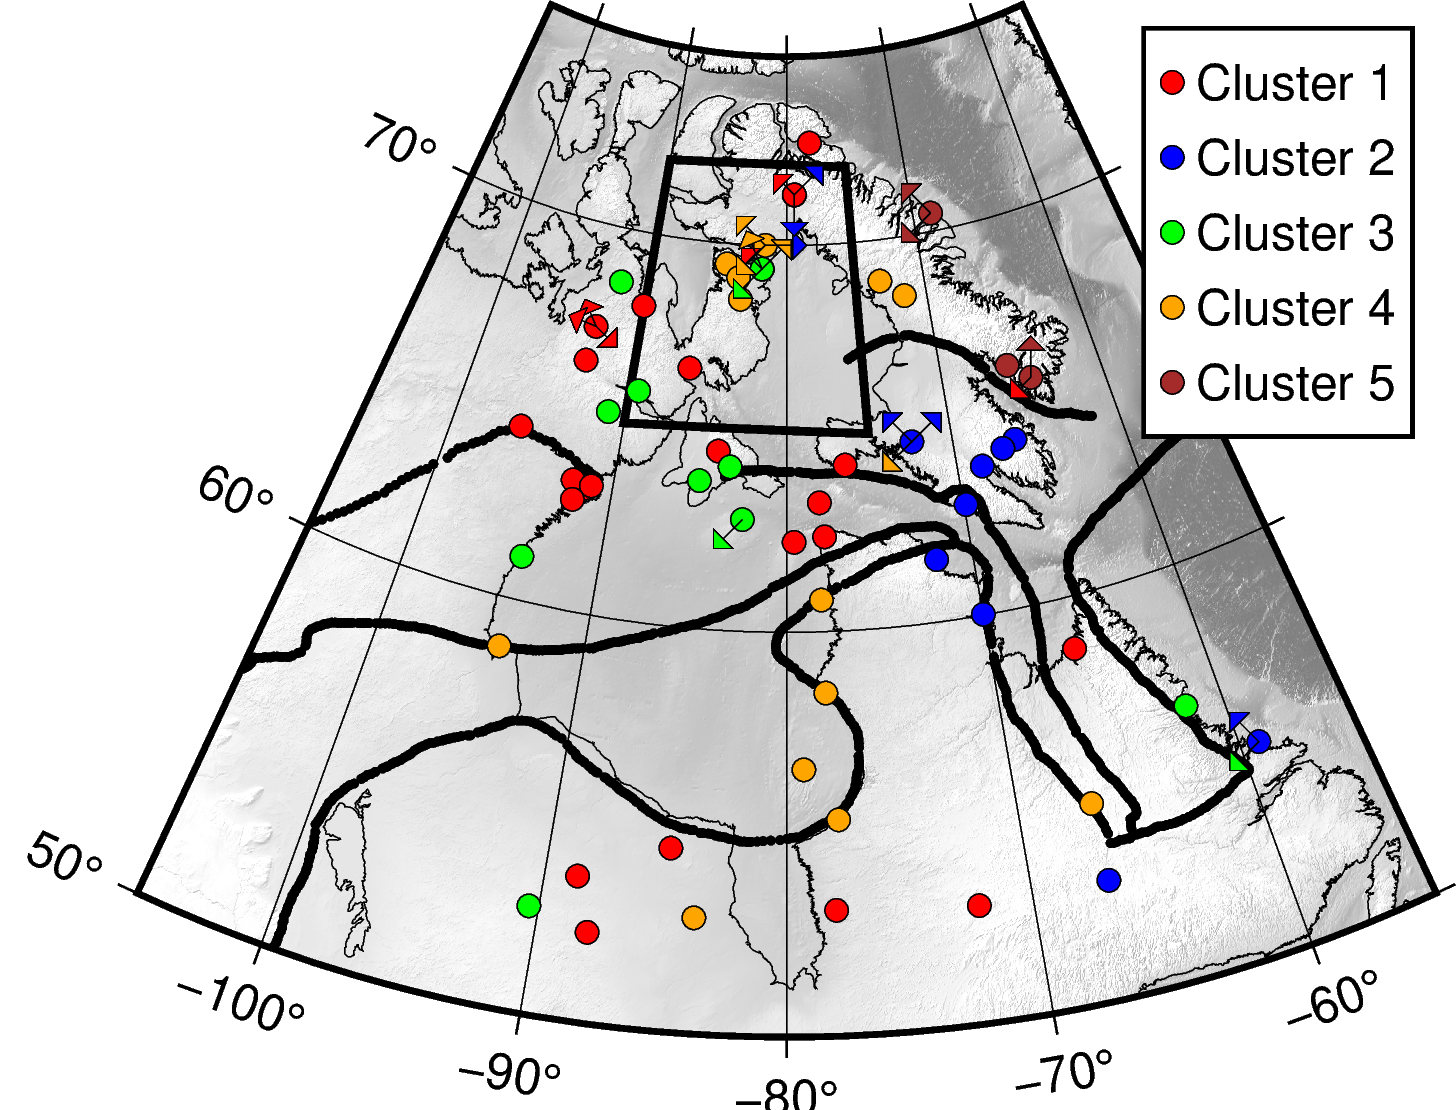

In [76]:
## Model Parameters 0.01, 4.48
stn_lons = new_mod_lons[labels_ac == np.unique(labels_ac)[0]]
stn_lats = new_mod_lats[labels_ac == np.unique(labels_ac)[0]]

stn_lons1 = new_mod_lons[labels_ac == np.unique(labels_ac)[1]]
stn_lats1 = new_mod_lats[labels_ac == np.unique(labels_ac)[1]]

stn_lons2 = new_mod_lons[labels_ac == np.unique(labels_ac)[2]]
stn_lats2 = new_mod_lats[labels_ac == np.unique(labels_ac)[2]]

stn_lons3 = new_mod_lons[labels_ac == np.unique(labels_ac)[3]]
stn_lats3 = new_mod_lats[labels_ac == np.unique(labels_ac)[3]]


stn_lons4 = new_mod_lons[labels_ac == np.unique(labels_ac)[4]]
stn_lats4 = new_mod_lats[labels_ac == np.unique(labels_ac)[4]]


region1 = [-90,-75,65,72]



###############################################################
sector_lons1 = sector_lons[sector_labels == np.unique(sector_labels)[0]] 
sector_lats1 = sector_lats[sector_labels == np.unique(sector_labels)[0]] 

sector_lons2 = sector_lons[sector_labels == np.unique(sector_labels)[1]] 
sector_lats2 = sector_lats[sector_labels == np.unique(sector_labels)[1]] 

sector_lons3 = sector_lons[sector_labels == np.unique(sector_labels)[2]] 
sector_lats3 = sector_lats[sector_labels == np.unique(sector_labels)[2]] 

sector_lons4 = sector_lons[sector_labels == np.unique(sector_labels)[3]] 
sector_lats4 = sector_lats[sector_labels == np.unique(sector_labels)[3]] 

sector_lons5 = sector_lons[sector_labels == np.unique(sector_labels)[4]] 
sector_lats5 = sector_lats[sector_labels == np.unique(sector_labels)[4]] 


sector_dir1 = sector_angles[sector_labels == np.unique(sector_labels)[0]] 
sector_dir2 = sector_angles[sector_labels == np.unique(sector_labels)[1]] 
sector_dir3 = sector_angles[sector_labels == np.unique(sector_labels)[2]]
sector_dir4 = sector_angles[sector_labels == np.unique(sector_labels)[3]]
sector_dir5 = sector_angles[sector_labels == np.unique(sector_labels)[4]]

### PyGMT script
region=[-105,-55, 50, 75]
fig = pygmt.Figure()
rectangle = [[region1[0], region1[2], region1[1], region1[3]]]
pygmt.makecpt(cmap='gray',series='-1000/500/50',continuous=True)
topo_data = '@earth_relief_01m'
fig.grdimage(grid=topo_data,region=region,projection='S-80/90/11c',cmap=True,shading=True,transparency=50)

#topo_data = '@earth_relief_01m'

#fig.grdimage(grid=topo_data,region=region,projection='S-80/90/11c',cmap='geo',shading=True)

pygmt.config(FORMAT_GEO_MAP="ddd")
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(MAP_ANNOT_MIN_SPACING = 0.25)
fig.coast(area_thresh = 10000,
    projection='S-80/90/11c',
    region=region,
    shorelines=True,
#    water="lightblue",
    resolution='i',
         frame=['ag',"WSne"])

fig.plot(x=fault1_lons,y=fault1_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault2_lons,y=fault2_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault3_lons,y=fault3_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault4_lons,y=fault4_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault5_lons,y=fault5_lats,style='c0.07c',color='black',pen='black',)


fig.plot(data=rectangle, style="r+s", pen="2p,black",projection='S-80/90/11c')    
    

fig.plot(
    x=stn_lons,
    y=stn_lats,
    style='c0.2c',
    color='red',
    pen='black',
    label='"Cluster 1"'
)

fig.plot(
    x=stn_lons2,
    y=stn_lats2,
    style='c0.2c',
    color='blue',
    pen='black',
    label='"Cluster 2"'
)


fig.plot(
    x=stn_lons3,
    y=stn_lats3,
    style='c0.2c',
    color='green',
    pen='black',
    label='"Cluster 3"'
)


fig.plot(
    x=stn_lons1,
    y=stn_lats1,
    style='c0.2c',
    color='orange',
    pen='black',
    label='"Cluster 4"'
)

fig.plot(
    x=stn_lons4,
    y=stn_lats4,
    style='c0.2c',
    color='brown',
    pen='black',
    label='"Cluster 5"'
)



fig.plot(projection='S-80/90/11c',
    x=sector_lons1,
    y=sector_lats1,
    style="v0.12c+e+a90+h0",
    direction=[sector_dir1, 0.25*np.ones(len(sector_lons1))],
    color='red',
    pen='black',
    )


fig.plot(projection='S-80/90/11c',
    x=sector_lons2,
    y=sector_lats2,
    style="v0.12c+e+a90+h0",
    direction=[sector_dir2, 0.35*np.ones(len(sector_lons2))],
    color='orange',
    pen='black',
    )


fig.plot(projection='S-80/90/11c',
    x=sector_lons3,
    y=sector_lats3,
    style="v0.12c+e+a90+h0",
    direction=[sector_dir3, 0.35*np.ones(len(sector_lons3))],
    color='blue',
    pen='black',
    )

  
fig.plot(projection='S-80/90/11c',
    x=sector_lons4,
    y=sector_lats4,
    style="v0.12c+e+a90+h0",
    direction=[sector_dir4, 0.35*np.ones(len(sector_lons4))],
    color='green',
    pen='black',
    )    
    
fig.plot(projection='S-80/90/11c',
    x=sector_lons5,
    y=sector_lats5,
    style="v0.12c+e+a90+h0",
    direction=[sector_dir5, 0.35*np.ones(len(sector_lons5))],
    color='brown',
    pen='black',
    )   

      


fig.legend(projection = 'S-80/90/11c', region=region, position = 'JTR+jTR+o0.2c+l1.5c', box='+gwhite+p1p', transparency=0)
fig.show()

grdimage [WARNING]: Transparency is expected in percentage.  Did you mean 0?


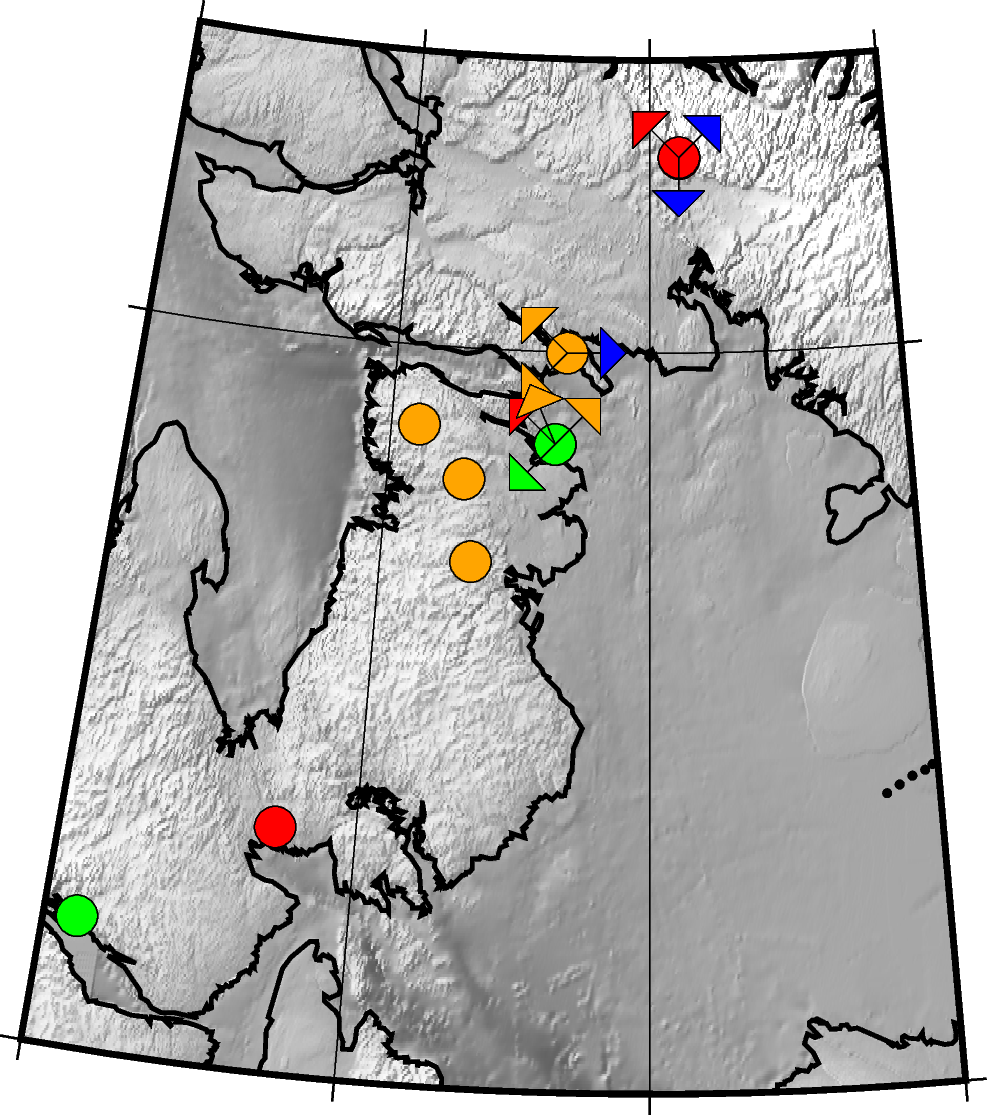

In [81]:
## Model Parameters 0.01, 4.48
stn_lons = new_mod_lons[labels_ac == np.unique(labels_ac)[0]]
stn_lats = new_mod_lats[labels_ac == np.unique(labels_ac)[0]]

stn_lons1 = new_mod_lons[labels_ac == np.unique(labels_ac)[1]]
stn_lats1 = new_mod_lats[labels_ac == np.unique(labels_ac)[1]]

stn_lons2 = new_mod_lons[labels_ac == np.unique(labels_ac)[2]]
stn_lats2 = new_mod_lats[labels_ac == np.unique(labels_ac)[2]]

stn_lons3 = new_mod_lons[labels_ac == np.unique(labels_ac)[3]]
stn_lats3 = new_mod_lats[labels_ac == np.unique(labels_ac)[3]]


stn_lons4 = new_mod_lons[labels_ac == np.unique(labels_ac)[4]]
stn_lats4 = new_mod_lats[labels_ac == np.unique(labels_ac)[4]]


region1 = [-90,-75,65,72]



###############################################################
sector_lons1 = sector_lons[sector_labels == np.unique(sector_labels)[0]] 
sector_lats1 = sector_lats[sector_labels == np.unique(sector_labels)[0]] 

sector_lons2 = sector_lons[sector_labels == np.unique(sector_labels)[1]] 
sector_lats2 = sector_lats[sector_labels == np.unique(sector_labels)[1]] 

sector_lons3 = sector_lons[sector_labels == np.unique(sector_labels)[2]] 
sector_lats3 = sector_lats[sector_labels == np.unique(sector_labels)[2]] 

sector_lons4 = sector_lons[sector_labels == np.unique(sector_labels)[3]] 
sector_lats4 = sector_lats[sector_labels == np.unique(sector_labels)[3]] 

sector_lons5 = sector_lons[sector_labels == np.unique(sector_labels)[4]] 
sector_lats5 = sector_lats[sector_labels == np.unique(sector_labels)[4]] 


sector_dir1 = sector_angles[sector_labels == np.unique(sector_labels)[0]] 
sector_dir2 = sector_angles[sector_labels == np.unique(sector_labels)[1]] 
sector_dir3 = sector_angles[sector_labels == np.unique(sector_labels)[2]]
sector_dir4 = sector_angles[sector_labels == np.unique(sector_labels)[3]]
sector_dir5 = sector_angles[sector_labels == np.unique(sector_labels)[4]]

### PyGMT script
region=region1
fig = pygmt.Figure()
rectangle = [[region1[0], region1[2], region1[1], region1[3]]]
pygmt.makecpt(cmap='gray',series='-1000/500/50',continuous=True)
topo_data = '@earth_relief_01m'
fig.grdimage(grid=topo_data,region=region,projection='S-80/90/8c',cmap=True,shading=True,transparency=0)

#topo_data = '@earth_relief_01m'

#fig.grdimage(grid=topo_data,region=region,projection='S-80/90/8c',cmap='geo',shading=True)

pygmt.config(FORMAT_GEO_MAP="ddd")
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(MAP_ANNOT_MIN_SPACING = 0.25)
fig.coast(area_thresh = 10000,
    projection='S-80/90/8c',
    region=region,
    shorelines='1p,black',
#    water="lightblue",
    resolution='i',
         frame=['ag',"wsne"])

fig.plot(x=fault1_lons,y=fault1_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault2_lons,y=fault2_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault3_lons,y=fault3_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault4_lons,y=fault4_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault5_lons,y=fault5_lats,style='c0.07c',color='black',pen='black',)


   
    

fig.plot(
    x=stn_lons,
    y=stn_lats,
    style='c0.35c',
    color='red',
    pen='black',
    label='"Cluster 1"'
)

fig.plot(
    x=stn_lons2,
    y=stn_lats2,
    style='c0.35c',
    color='blue',
    pen='black',
    label='"Cluster 2"'
)


fig.plot(
    x=stn_lons3,
    y=stn_lats3,
    style='c0.35c',
    color='green',
    pen='black',
    label='"Cluster 3"'
)


fig.plot(
    x=stn_lons1,
    y=stn_lats1,
    style='c0.35c',
    color='orange',
    pen='black',
    label='"Cluster 4"'
)

fig.plot(
    x=stn_lons4,
    y=stn_lats4,
    style='c0.35c',
    color='brown',
    pen='black',
    label='"Cluster 5"'
)



fig.plot(projection='S-80/90/8c',
    x=sector_lons1,
    y=sector_lats1,
    style="v0.22c+e+a90+h0",
    direction=[sector_dir1, 0.55*np.ones(len(sector_lons1))],
    color='red',
    pen='black',
    )


fig.plot(projection='S-80/90/8c',
    x=sector_lons2,
    y=sector_lats2,
    style="v0.22c+e+a90+h0",
    direction=[sector_dir2, 0.55*np.ones(len(sector_lons2))],
    color='orange',
    pen='black',
    )


fig.plot(projection='S-80/90/8c',
    x=sector_lons3,
    y=sector_lats3,
    style="v0.22c+e+a90+h0",
    direction=[sector_dir3, 0.5*np.ones(len(sector_lons3))],
    color='blue',
    pen='black',
    )

  
fig.plot(projection='S-80/90/8c',
    x=sector_lons4,
    y=sector_lats4,
    style="v0.22c+e+a90+h0",
    direction=[sector_dir4, 0.55*np.ones(len(sector_lons4))],
    color='green',
    pen='black',
    )    
    
fig.plot(projection='S-80/90/8c',
    x=sector_lons5,
    y=sector_lats5,
    style="v0.22c+e+a90+h0",
    direction=[sector_dir5, 0.55*np.ones(len(sector_lons5))],
    color='brown',
    pen='black',
    )   

      


#fig.legend(projection = 'S-80/90/11c', region=region, position = 'JTR+jTR+o0.2c+l1.5c', box='+gwhite+p1p', transparency=0)
fig.show()

In [85]:
len(sector_stations)

23

In [84]:
len(sectors)

23

In [88]:
az_stations = []

for i in range(len(sector_stations)):
    az_stations.append(sector_stations[i]+'_'+sectors[i])

In [90]:
az_stations = np.array(az_stations)

In [93]:
new_stns = np.concatenate([stations, az_stations])

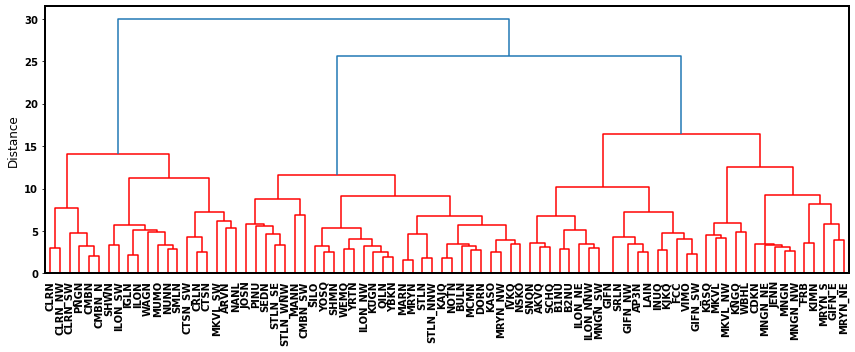

In [96]:
plot_dendrogram(quantity=X_p1,method='ward', stn_labels= new_stns, d=[0,25])